# Analyse et classification des critiques des films

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

%config IPCompleter.greedy = True
%matplotlib inline

In [2]:
!pip install nltk
!pip install contractions


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
import contractions
from nltk.stem import PorterStemmer, WordNetLemmatizer


In [8]:
df = pd.read_csv("./data/IMDB dataset.csv")
df.shape

(50000, 2)

In [9]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

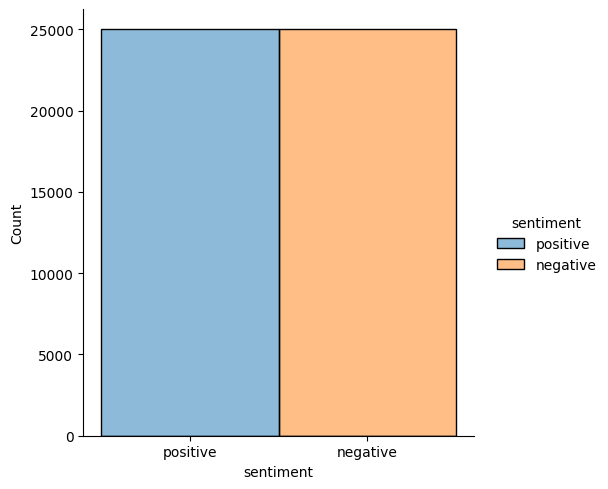

<Figure size 1600x700 with 0 Axes>

In [11]:
sns.displot(df,x='sentiment',hue="sentiment")
plt.figure(figsize=(16,7))
plt.show()

## Data cleaning

In [13]:
"""

* Chaque mot est transformer en miniscule avec lower.
* on utilise une expression reguliere pour remplacer  : les balise html, les retour a la ligne, les caractere spéciaux qui ne sont pas des point ou des virgule  (par exemple, !, ?, :) ,les underscore, les points, les virgules, les espace multiple et les mots non anglais par un espace vide
* on supprime toutes les contraction (example: can't devient can not et it's devient it is) .
* chaque mot qui n'est pas un stop_word (and, or, but, etc) est tokenizer et on retour sa basse (ex : terreste devient terre)

"""

def cleaning_sentiment(df,col_name):
    porter = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    w = df[col_name].apply(lambda x :x.lower())
    w = w.apply(lambda x: re.sub('(<.*?>)|(\n)|([^\w\s\.\,])|([_])|([.])|([,])|(\s\s+)|([ا-ي])','',x))
    w = w.apply(lambda x: contractions.fix(x))
    w = w.apply(lambda x: ' '.join([porter.stem(i) for i in word_tokenize(x) if i not in stop_words]))
    return w

cleaning_sentiment(df,'review')

0        one review mention watch 1 oz episod hook righ...
1        wonder littl product film techniqu unassum old...
2        thought wonder way spend time hot summer weeke...
3        basic famili littl boy jake think zombi closet...
4        petter mattei love time money visual stun film...
                               ...                        
49995    thought movi right good job creativ origin fir...
49996    bad plot bad dialogu bad act idiot direct anno...
49997    cathol taught parochi elementari school nun ta...
49998    go disagre previou comment side maltin one sec...
49999    one expect star trek movi high art fan expect ...
Name: review, Length: 50000, dtype: object

In [14]:
df['review_cleaning'] = cleaning_sentiment(df,'review')

In [15]:
df['review_cleaning'][:2]

0    one review mention watch 1 oz episod hook righ...
1    wonder littl product film techniqu unassum old...
Name: review_cleaning, dtype: object

## Vectorisation avec TF-IDF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [17]:
X = df['review_cleaning']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f' train {X_train.shape}')
print(f' test {X_test.shape}')

 train (35000,)
 test (15000,)


In [18]:
tfidf_vector = TfidfVectorizer(stop_words='english', max_features=None, max_df=0.5, min_df=2, ngram_range=(1,1))

X_train = tfidf_vector.fit_transform(X_train)
X_test = tfidf_vector.transform(X_test)

## Model

## 1- Logistic regression

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(random_state=42)
lr = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

coef_abs = abs(lr.coef_[0]).tolist()
feature_scores = pd.Series(coef_abs).sort_values(ascending=False)
lr_best_index = feature_scores[:10].index


for index in lr_best_index:
    print(f' feature : {index} :', {tfidf_vector.get_feature_names_out()[index]})


              precision    recall  f1-score   support

    negative       0.90      0.87      0.88      7411
    positive       0.88      0.90      0.89      7589

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

 feature : 45146 : {'worst'}
 feature : 43945 : {'wast'}
 feature : 3682 : {'bad'}
 feature : 3468 : {'aw'}
 feature : 17155 : {'great'}
 feature : 13491 : {'excel'}
 feature : 5508 : {'bore'}
 feature : 31308 : {'poor'}
 feature : 40013 : {'terribl'}
 feature : 28228 : {'noth'}


## 2-Random forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(min_samples_split=5 ,max_depth=10, random_state=42)
rf = rf.fit(X_train, y_train)
y_pred2 = rf.predict(X_test)

print(classification_report(y_test, y_pred2))

# Obtenir les index des importances de fonctionnalités pour chaque classe
feature_scores = pd.Series(rf.feature_importances_).sort_values(ascending=False)
rf_best_index = feature_scores[:10].index
for index in rf_best_index:
    print(f' feature : {index} :', {tfidf_vector.get_feature_names_out()[index]})


              precision    recall  f1-score   support

    negative       0.85      0.81      0.83      7411
    positive       0.82      0.86      0.84      7589

    accuracy                           0.83     15000
   macro avg       0.83      0.83      0.83     15000
weighted avg       0.83      0.83      0.83     15000

 feature : 3682 : {'bad'}
 feature : 45146 : {'worst'}
 feature : 40013 : {'terribl'}
 feature : 17155 : {'great'}
 feature : 38753 : {'stupid'}
 feature : 43945 : {'wast'}
 feature : 4247 : {'beauti'}
 feature : 5508 : {'bore'}
 feature : 28228 : {'noth'}
 feature : 9330 : {'crap'}


## 3-LinearSV

In [21]:
from sklearn.svm import LinearSVC

svm = LinearSVC(random_state=42)
svm = svm.fit(X_train, y_train)
y_pred3 = svm.predict(X_test)

print(classification_report(y_test, y_pred3))

coef_abs = abs(svm.coef_[0]).tolist()
feature_scores = pd.Series(coef_abs).sort_values(ascending=False)
svm_best_index = feature_scores[:10].index


for index in svm_best_index:
    print(f' feature : {index} :', {tfidf_vector.get_feature_names_out()[index]})


              precision    recall  f1-score   support

    negative       0.89      0.88      0.89      7411
    positive       0.88      0.90      0.89      7589

    accuracy                           0.89     15000
   macro avg       0.89      0.89      0.89     15000
weighted avg       0.89      0.89      0.89     15000

 feature : 45146 : {'worst'}
 feature : 43945 : {'wast'}
 feature : 848 : {'710'}
 feature : 682 : {'410'}
 feature : 3468 : {'aw'}
 feature : 13491 : {'excel'}
 feature : 5508 : {'bore'}
 feature : 903 : {'810'}
 feature : 31308 : {'poor'}
 feature : 13873 : {'fail'}


## 4- MultinomialNB

In [22]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb = nb.fit(X_train, y_train)
y_pred4 = nb.predict(X_test)

print(classification_report(y_test, y_pred4))

coef_abs = abs(nb.coef_[0]).tolist()
feature_scores = pd.Series(coef_abs).sort_values(ascending=False)
nb_best_index = feature_scores[:10].index


for index in nb_best_index:
    print(f' feature : {index} :', {tfidf_vector.get_feature_names_out()[index]})



              precision    recall  f1-score   support

    negative       0.85      0.86      0.86      7411
    positive       0.87      0.85      0.86      7589

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



AttributeError: 'MultinomialNB' object has no attribute 'coef_'